# timeseriesAI


timeseriesAI is a library built on top of fastai/ Pytorch to help you apply Deep Learning to your time series/ sequential datasets, in particular Time Series Classification (TSC) and Time Series Regression (TSR) problems.


The library contains 3 major components: 

1. **Notebooks** 📒: they are very practical, and show you how certain techniques can be easily applied. 

2. **fastai_timeseries** 🏃🏽‍♀️: it's an extension of fastai's library that focuses on time series/ sequential problems. 

3. **torchtimeseries.models** 👫: it's a collection of some state-of-the-art time series/ sequential models.


## Notebooks

#### 1. Introduction to Time Series Classification (TSC): 
- This is an intro that nb that shows you how you can achieve high performance in 4 simple steps.

#### 2. UCR_TCS:
- The UCR datasets are broadly used in TSC problems as s bechmark to measure performance. This notebook will allow you to test any of the available datasets, with the model of your choice and any training scheme. You can easily tweak any of them to try to beat a SOTA.

#### 3. New TS data augmentations: 
- You will see how you can apply successful data augmentation techniques (like mixup, cutout, and cutmix) to time series problems.


In [5]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## 00. Purpose 😇

The purpose of this notebook is to show you how you can create a simple, state-of-the-art time series classification model using the great **fastai-v1** library in 4 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model

In general, there are 3 main ways to classify time series, based on the input to the neural network:

- raw data

- image data (encoded from raw data)

- feature data (extracted from raw data)

In this notebook, we will use the first approach. We will cover other approaches in future notebooks.

Throughout the notebook you will see this ✳️. It means there's some value you need to select.

## 01. Import libraries 📚

There are some dependencies you need to have installed to be able to run this repo. If you don't have these packages you will need to install them: 
- pip install Cython
- pip install tslearn
- pip install PyWavelets
- pip install pyts
- pip install fire
- pip install nvidia-ml-py3

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import fastai, os
from fastai_timeseries import *
from torchtimeseries.models import *
path = Path(os.getcwd())
print(path)
print('fastai :', fastai.__version__)
print('torch  :', torch.__version__)
print('device :', device)

C:\Users\qq834\Google Drive\mohcineblog\Draft\timeseriesAI
fastai : 1.0.58
torch  : 1.1.0
device : cuda


## 02. Prepare data 🔢

### Download data ⬇️

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.


In [11]:
pprint.pprint(get_UCR_univariate_list())

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGtorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [5]:
#pprint.pprint(get_UCR_multivariate_list())

In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

In [12]:
# dataset id
dsid = 'ChlorineConcentration'   # ✳️

In [13]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Features
3. Sequence length (aka time steps)

All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

### Prepare databunch 💿

You always need to define the bs at the time of creating the databunch, the object that contains all data required.

It's also best practice to scale the data using the train stats. There are several options available: 

1. standardization or normalization.

2. calculate them based on all samples, per channel or per sample. 

3. scale range (for normalization only).

The most common practice is to standardize data per channel.

In [14]:
bs = 64                            # ✳️
seed = 1234                        # ✳️
scale_type = 'standardize'         # ✳️ 'standardize', 'normalize'
scale_subtype = 'per_channel'      # ✳️ 'all_samples', 'per_channel', 'per_sample'
scale_range = (-1, 1)              # ✳️ for normalization only: usually left to (-1, 1)

Now, the last step in data preparation is to prepare a databunch.
Time series data may come as numpy arrays, pandas dataframes, etc.
The 2 most common ways to load data into a databunch will be from a numpy array/ torch tensors or a pandas dataframe. Let's see how we'd work in either case. 

#### From 3D numpy arrays/ torch tensors

1) You need to first create ItemLists from TimeSeriesList (custom type of ItemList built for Time Series)

2) You need to label the ItemLists. You'll find a lot of information [here](https://docs.fast.ai/data_block.html)

3) You enter the train bs and val_bs and crate the databunch object. 

4) You add features and seq_len.

In [15]:
db = (ItemLists('.', TimeSeriesList(X_train), TimeSeriesList(X_valid))
      .label_from_lists(y_train, y_valid)
      .databunch(bs=min(bs, len(X_train)), val_bs=min(len(X_valid), bs * 2), num_workers=cpus, device=device)
      .scale(scale_type=scale_type, scale_subtype=scale_subtype, scale_range=scale_range)
     )
db

TSDataBunch;

Train: LabelList (467 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166)
y: CategoryList
1,3,1,3,2
Path: .;

Valid: LabelList (3840 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166)
y: CategoryList
2,2,1,3,2
Path: .;

Test: None

#### From pandas dataframe

In [18]:
dsid = 'NATOPS' 
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)
for ch in range(X_train.shape[-2]):
    data_ch = np.concatenate((np.full((len(np.concatenate((X_train, X_valid))), 1), ch),
                              np.concatenate((X_train, X_valid))[:, ch], 
                              np.concatenate((y_train, y_valid))[:, None]), axis=-1)
    if ch == 0: data = data_ch
    else: data = np.concatenate((data, data_ch))
df = pd.DataFrame(data, columns=['feat'] + list(np.arange(X_train.shape[-1]).astype('str')) + ['target'])
df.to_csv(path/f'data/UCR/{dsid}/{dsid}.csv', index=False)
pd.read_csv(path/f'data/UCR/{dsid}/{dsid}.csv')
print(df.shape)
df.head()

(8640, 53)


,feat,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,50,target
0,0.0,-0.372758,-0.367844,-0.378445,-0.386751,-0.417101,-0.447204,-0.423585,-0.318506,-0.144364,...,-0.477529,-0.487402,-0.485995,-0.480247,-0.496073,-0.491603,-0.537007,-0.475939,-0.479505,0.0
1,0.0,-0.547370,-0.546334,-0.549748,-0.546891,-0.550253,-0.548429,-0.549099,-0.556074,-0.555707,...,-0.530492,-0.537032,-0.528957,-0.520373,-0.530154,-0.528187,-0.533726,-0.528338,-0.518618,1.0
2,0.0,-0.587062,-0.587322,-0.586417,-0.584654,-0.585361,-0.583648,-0.582933,-0.583448,-0.585703,...,-0.598846,-0.596118,-0.594087,-0.598232,-0.604513,-0.607462,-0.606236,-0.602293,-0.600885,1.0
3,0.0,-0.514671,-0.518640,-0.521285,-0.522843,-0.529080,-0.589589,-0.735513,-0.963720,-1.168972,...,-1.566254,-1.210887,-0.879528,-0.638007,-0.532520,-0.577928,-0.628697,-0.632625,-0.606548,0.0
4,0.0,-0.718601,-0.721093,-0.717955,-0.722386,-0.728969,-0.722774,-0.730497,-0.737313,-0.739868,...,-0.680790,-0.686406,-0.704122,-0.722950,-0.708337,-0.690788,-0.692195,-0.702812,-0.701643,1.0


In [19]:
dsid = 'NATOPS'   # ✳️
df = pd.read_csv(path/f'data/UCR/{dsid}/{dsid}.csv')
print(df.shape)
display(df.head())

(8640, 53)


,feat,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,50,target
0,0.0,-0.372758,-0.367844,-0.378445,-0.386751,-0.417101,-0.447204,-0.423585,-0.318506,-0.144364,...,-0.477529,-0.487402,-0.485995,-0.480247,-0.496073,-0.491603,-0.537007,-0.475939,-0.479505,0.0
1,0.0,-0.547370,-0.546334,-0.549748,-0.546891,-0.550253,-0.548429,-0.549099,-0.556074,-0.555707,...,-0.530492,-0.537032,-0.528957,-0.520373,-0.530154,-0.528187,-0.533726,-0.528338,-0.518618,1.0
2,0.0,-0.587062,-0.587322,-0.586417,-0.584654,-0.585361,-0.583648,-0.582933,-0.583448,-0.585703,...,-0.598846,-0.596118,-0.594087,-0.598232,-0.604513,-0.607462,-0.606236,-0.602293,-0.600885,1.0
3,0.0,-0.514671,-0.518640,-0.521285,-0.522843,-0.529080,-0.589589,-0.735513,-0.963720,-1.168972,...,-1.566254,-1.210887,-0.879528,-0.638007,-0.532520,-0.577928,-0.628697,-0.632625,-0.606548,0.0
4,0.0,-0.718601,-0.721093,-0.717955,-0.722386,-0.728969,-0.722774,-0.730497,-0.737313,-0.739868,...,-0.680790,-0.686406,-0.704122,-0.722950,-0.708337,-0.690788,-0.692195,-0.702812,-0.701643,1.0


🔎 To create the TimeSeriesList, you need to select the columns that contain the time series only, neither the target, not the feature (for multivariate TS).

🔎 You should use **label_cls=CategoryList** when labels are floats but it is a classification problem. Otherwise, the fastai library would take it as a regression problem.

1) You need to first TimeSeriesList (custom type of ItemList built for Time Series) from the dataframe. As cols you should only enter the data from the time series (X values, not y).

2) Then you split the TimeSeriesList into 2 lists (traina and valid). There are multiple ways to do that. More info [here](https://docs.fast.ai/data_block.html)

3) You need to label the ItemLists. You'll find a lot of information [here](https://docs.fast.ai/data_block.html)

4) You enter the train bs and val_bs and crate the databunch object. 

5) You add features and seq_len.

In [21]:
db = (TimeSeriesList.from_df(df, '.', cols=df.columns.values[:-1], feat='feat')
      .split_by_rand_pct(valid_pct=0.2, seed=seed)
      .label_from_df(cols='target', label_cls=CategoryList)
      .databunch(bs=bs,  val_bs=bs * 2,  num_workers=cpus,  device=device)
      .scale(scale_type=scale_type, scale_subtype=scale_subtype, scale_range=scale_range)
     )
db

TSDataBunch;

Train: LabelList (288 items)
x: TimeSeriesList
TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52)
y: CategoryList
1.0,1.0,0.0,1.0,2.0
Path: .;

Valid: LabelList (72 items)
x: TimeSeriesList
TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52),TimeSeries(ch=24, seq_len=52)
y: CategoryList
3.0,5.0,2.0,0.0,4.0
Path: .;

Test: None

### Visualize data

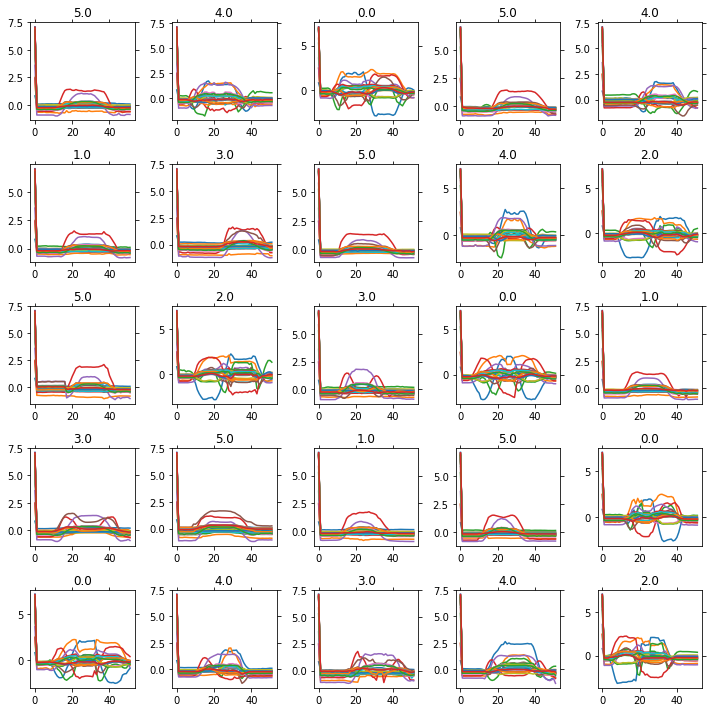

In [22]:
db.show_batch()

## 03. Build learner 🏗

In [23]:
from torchtimeseries.models import *
# Select one arch from these state-of-the-art time series/ 1D models:
# ResCNN, FCN, InceptionTime, ResNet
arch = InceptionTime                     # ✳️   
arch_kwargs = dict()                     # ✳️ 
opt_func=Ranger                          # ✳️ a state-of-the-art optimizer
loss_func = LabelSmoothingCrossEntropy() # ✳️

In [24]:
model = arch(db.features, db.c, **arch_kwargs).to(device)
learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
learn.save('stage_0')
print(learn.model)
print(learn.summary())

InceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(24, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(24, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(24, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(24, 32, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): Inception(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (conv_layers): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))


## 04. Train model 🚵🏼‍

### LR find 🔎

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.75E-01


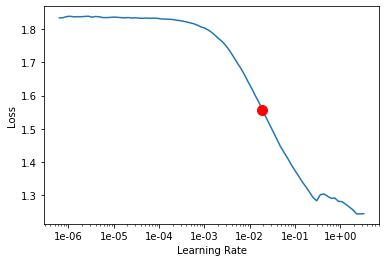

In [25]:
learn.load('stage_0')
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Train 🏃🏽‍♀️

In [26]:
epochs = 100         # ✳️ 
max_lr = 1e-2        # ✳️ 
warmup = False       # ✳️
pct_start = .7       # ✳️
metrics = [accuracy] # ✳️
wd = 1e-2

In [ ]:
learn.metrics = metrics
learn.load('stage_0')
learn.fit_one_cycle(epochs, max_lr=max_lr, pct_start=pct_start, moms=(.95, .85) if warmup else (.95, .95),
                    div_factor=25.0 if warmup else 1., wd=wd)
learn.save('stage_1')
learn.recorder.plot_lr()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,1.803898,1.792291,0.166667,02:39
1,1.735648,1.786683,0.166667,02:39
2,1.612863,1.773017,0.166667,02:39
3,1.480261,1.743848,0.250000,02:39
4,1.360391,1.684378,0.597222,02:40
5,1.259697,1.414256,0.763889,02:41
6,1.174970,1.170152,0.819444,02:43
7,1.102794,0.943973,0.819444,02:40
8,1.042045,0.790377,0.875000,02:41
9,0.988180,0.710910,0.875000,02:38


In [24]:
archs_names, acc_, acces_, acc5_, n_params_,  = [], [], [], [], []
archs_names.append(arch.__name__)
early_stop = math.ceil(np.argmin(learn.recorder.losses) / len(learn.data.train_dl))
acc_.append('{:.5}'.format(learn.recorder.metrics[-1][0].item()))
acces_.append('{:.5}'.format(learn.recorder.metrics[early_stop - 1][0].item()))
acc5_.append('{:.5}'.format(np.mean(np.max(learn.recorder.metrics))))
n_params_.append(count_params(learn))
clear_output()
df = (pd.DataFrame(np.stack((archs_names, acc_, acces_, acc5_, n_params_)).T,
                   columns=['arch', 'accuracy', 'accuracy train loss', 'max_accuracy','n_params'])
      .sort_values('accuracy train loss', ascending=False).reset_index(drop=True))
display(df)

,arch,accuracy,accuracy train loss,max_accuracy,n_params
0,InceptionTime,0.88359,0.88385,0.89193,406307


### Results

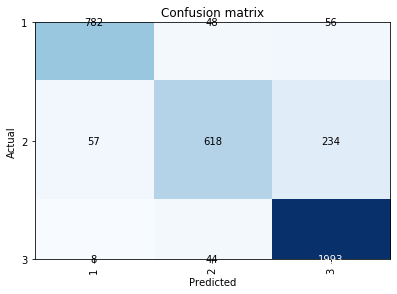

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()